   N               = 10
   shots           = 50000
   sample mean     = 5.0065   (ideal 5.0)
   sample variance = 2.5037  (ideal 2.5)
   total-var dist  = 5.1534e-03


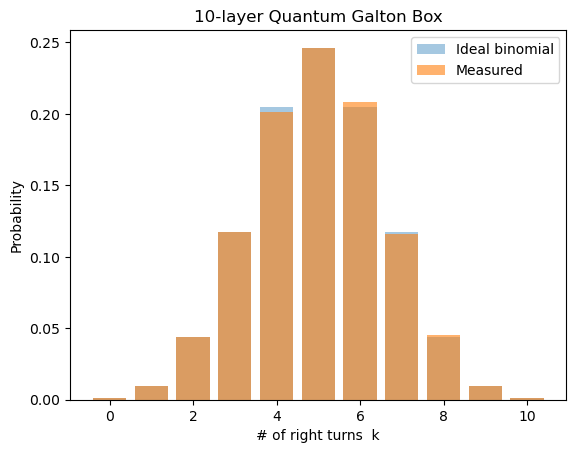

In [24]:

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from math import comb, sqrt, pi

# Citcuit

def galton_samples(n_layers: int, shots: int = 20_000, theta=pi/2):
    """
    Generate `shots` samples from an N-layer quantum Galton box.
    
    Parameters
    ----------
    n_layers : int
        Number of coin flips / board rows.
    shots : int
        How many repetitions (histogram statistics).
    theta : float, optional
        Rotation angle.  θ = π/2  →  Hadamard (fair coin).
        Keep θ=π/2 for the Gaussian deliverable.
    
    Returns
    -------
    numpy.ndarray
        Array of length `shots`; each entry k ∈ {0..N} is the count of "right"
        outcomes in that shot.
    """
    dev = qml.device("default.mixed", wires=n_layers, shots=shots)

    @qml.qnode(dev)
    def circuit():
        for w in range(n_layers):
            qml.RX(theta, wires=w)          # Hadamard if θ = π/2
        return qml.sample()

    bitstrings = circuit()                 # shape (shots, n_layers)
    return bitstrings.sum(axis=1)          # number of rights per shot


# Verification 

def binomial_pmf(n, p=0.5):
    return np.array([comb(n, k) * p**k * (1-p)**(n-k) for k in range(n+1)])

def tv_distance(emp_counts, ideal_pmf, shots):
    emp_pmf = emp_counts / shots
    return 0.5 * np.abs(emp_pmf - ideal_pmf).sum()

def verify_galton(samples, n_layers, plot=True):
    shots = len(samples)
    counts = np.bincount(samples, minlength=n_layers+1)
    ideal = binomial_pmf(n_layers)

    mu_hat  = samples.mean()
    var_hat = samples.var(ddof=0)

    print(f"   N               = {n_layers}")
    print(f"   shots           = {shots}")
    print(f"   sample mean     = {mu_hat:.4f}   (ideal {n_layers/2})")
    print(f"   sample variance = {var_hat:.4f}  (ideal {n_layers/4})")
    print(f"   total-var dist  = {tv_distance(counts, ideal, shots):.4e}")

    if plot:
        xs = np.arange(n_layers+1)
        plt.bar(xs, ideal, alpha=0.4, label="Ideal binomial")
        plt.bar(xs, counts/shots, alpha=0.6, label="Measured")
        plt.xlabel("# of right turns  k")
        plt.ylabel("Probability")
        plt.title(f"{n_layers}-layer Quantum Galton Box")
        plt.legend(); plt.show()

# TESTING 

N      = 10          # any integer ≥ 1
SHOTS  = 50000

sample_data = galton_samples(N, shots=SHOTS)   # quantum sampling
verify_galton(sample_data, N)                  # stats + histogram


0: ──RX(1.57)─┤  Sample
1: ──RX(1.57)─┤  Sample
2: ──RX(1.57)─┤  Sample
3: ──RX(1.57)─┤  Sample
4: ──RX(1.57)─┤  Sample
5: ──RX(1.57)─┤  Sample


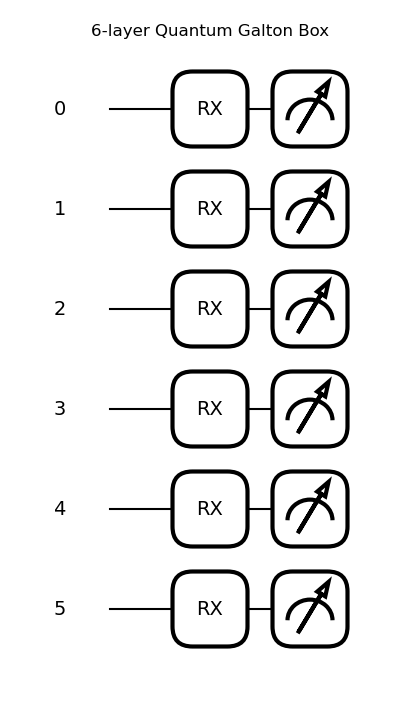

In [12]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt     # only needed if you want the fancy picture

# -------------------------------
# 1.  User-configurable settings
# -------------------------------
N     = 6          # number of Galton layers (rows / coin flips)
SHOTS = 10_000     # how many repetitions for statistics

# -------------------------------
# 2.  Device: all-to-all, noiseless
# -------------------------------
dev = qml.device("default.qubit", wires=N, shots=SHOTS)

# -------------------------------
# 3.  QNode (= quantum function)
# -------------------------------
@qml.qnode(dev)
def galton_box(theta=np.pi/2):
    """Quantum Galton box with uniform bias angle θ.
       θ = π/2   → Hadamard (fair), produces a binomial/Gaussian.
    """
    for w in range(N):
        qml.RX(theta, wires=w)      # RX(π/2) is |0⟩ ↦ (|0⟩ + i|1⟩)/√2  (fair coin)
    return qml.sample()             # bitstring for every shot

# --------------------------------
# 4.  Draw the circuit (two options)
# --------------------------------
print(qml.draw(galton_box)())       # ASCII text

# OR comment the line above and use the matplotlib drawer:
fig, ax = qml.draw_mpl(galton_box)()
fig.suptitle(f"{N}-layer Quantum Galton Box")
plt.show()
